<a href="https://colab.research.google.com/github/Ali-Asgar-Lakdawala/Forcasting/blob/main/Monthly_milk_production_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
import pandas as pd

In [156]:
df=pd.read_csv('https://raw.githubusercontent.com/Ali-Asgar-Lakdawala/Forcasting/main/data/monthlyMilkProduction.csv')

In [157]:
df['Month']=pd.to_datetime(df['Month'])

In [158]:
df=df.set_index(df['Month']).drop('Month',axis=1)

In [159]:
df

,Monthly milk production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


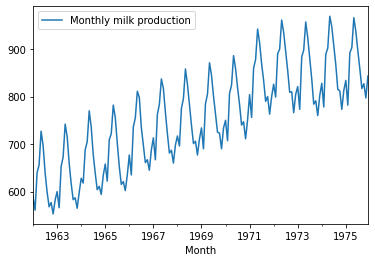

In [160]:
df.plot()

In [161]:
from statsmodels.tsa.stattools import adfuller

In [162]:
adfuller(df['Monthly milk production'])

(-1.3038115874221299,
 0.6274267086030314,
 13,
 154,
 {'1%': -3.473542528196209,
  '10%': -2.576878053634677,
  '5%': -2.880497674144038},
 1115.1730447395112)

In [163]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [164]:
adfuller_test(df['Monthly milk production'])

ADF Test Statistic : -1.3038115874221299
p-value : 0.6274267086030314
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [165]:
df['Monthly milk production']=df['Monthly milk production']-df['Monthly milk production'].shift(1)
df['Monthly milk production']=df['Monthly milk production']-df['Monthly milk production'].shift(12)

In [166]:
adfuller_test(new_df['Monthly milk production'].dropna())

ADF Test Statistic : -3.0549955586531126
p-value : 0.030068004001782136
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


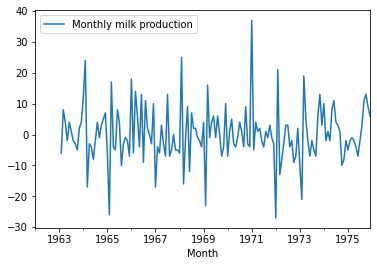

In [167]:
df.plot()

In [168]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [169]:
import matplotlib.pyplot as plt


p,d,q p

p AR model lags 
 
d differencing 
 
q MA lags

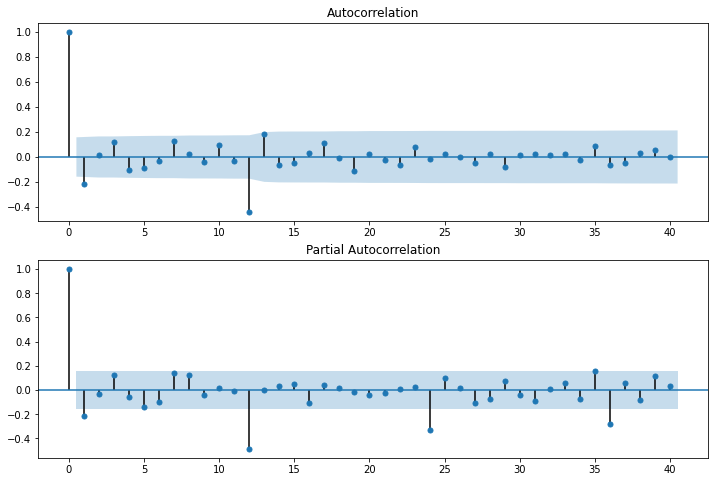

In [170]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Monthly milk production'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Monthly milk production'].iloc[13:],lags=40,ax=ax2)